In [1]:
from neo.core import SpikeTrain
from scipy import stats
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import pair_confusion_matrix,contingency_matrix
from sklearn.metrics.cluster import rand_score
from statannot import add_stat_annotation
from subprocess import call
from tqdm import tqdm
import dabest as db
import elephant as eph
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import quantities as q
import re
import seaborn as sns
import shutil
import sys
import time
import zipfile
%config Completer.use_jedi = False

In [2]:
def get_connectivity_timeseries(mat_no,odor_no,replicate,switch_prob = 0.3):
    n_n = 120
    p_n = 90
    l_n = 30

    pPNPN = 0.0
    pPNLN = 0.1
    pLNPN = 0.2

    ach_mat = np.zeros((n_n,n_n))
    np.random.seed(64163+mat_no) # Random.org
    ach_mat[p_n:,:p_n] = np.random.choice([0.,1.],size=(l_n,p_n),p=(1-pPNLN,pPNLN))
    ach_mat[:p_n,:p_n] = np.random.choice([0.,1.],size=(p_n,p_n),p=(1-pPNPN,pPNPN))
    
    PNLN = ach_mat[p_n:,:p_n]
    
    LNPN = np.zeros((p_n,l_n))
    stride = int(p_n/l_n)
    spread = (round(pLNPN*p_n)//2)*2+1 # Round to closest odd integer
    center = 0
    index = np.arange(p_n)
    for i in range(l_n):
        idx = index[np.arange(center-spread//2,1+center+spread//2)%p_n]
        LNPN[idx,i] = 1
        center+=stride

    fgaba_mat = np.zeros((n_n,n_n))
    fgaba_mat[:p_n,p_n:] = LNPN # LN->PN
    fgaba_mat[p_n:,p_n:] = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=',') # LN->LN
    np.fill_diagonal(fgaba_mat,0.)

    sgaba_mat = np.zeros((n_n,n_n))
    sgaba_mat[:p_n,p_n:] = LNPN
    np.fill_diagonal(sgaba_mat,0.)

    blocktime = 12000 # in ms
    buffer = 500 # in ms
    sim_res = 0.01 # in ms
    min_block = 50 # in ms

    np.random.seed(mat_no+odor_no+replicate)
    sw_state = [0]
    for i in np.random.choice([0,1],p=[1-switch_prob,switch_prob],size=int(blocktime/min_block)-1):
        if i==1:
            sw_state.append(1-sw_state[-1])
        else:
            sw_state.append(sw_state[-1])
    ts = np.repeat(sw_state,int(min_block/sim_res))
    
    sim_time = blocktime + 2*buffer
    t = np.arange(0,sim_time,sim_res)
    np.random.seed(odor_no)
    setpn = np.concatenate([np.ones(9),np.zeros(81)])
    np.random.shuffle(setpn)
    ts = np.concatenate([np.zeros(int(buffer/sim_res)),ts,np.zeros(int(buffer/sim_res))])
    return PNLN,LNPN,setpn,t,ts

def get_traces(mat_no,odor_no,replicate):
    return np.load(f"Data/data_{mat_no}_{odor_no}_{replicate}.npy")

def get_LN_data(mat_no,odor_no,replicate=None):
    r = []
    mat = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=",")
    module = np.loadtxt(f'../modules/networks/matrix_{mat_no}_modules.csv')
    order = np.argsort(module)
    if replicate is None:
        for i in filter(lambda v: ".npy" in v and f"{mat_no}_{odor_no}" in v,os.listdir('Data')):
            temp = np.load(f"Data/{i}").T
            spikes = np.logical_and(temp[90:,1:]>=-20,temp[90:,:-1]<-20)
            event = np.array([SpikeTrain(np.linspace(0,12.998,12999)[k>0]*q.s,t_stop=13*q.s) for k in spikes],dtype=object)
            bst = eph.conversion.BinnedSpikeTrain(list(event),bin_size=50*q.ms)
            pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
            r.append(pearson_correlation[:,order][order,:])
    else:
        temp = np.load(f"Data/data_{mat_no}_{odor_no}_{replicate}.npy").T
        spikes = np.logical_and(temp[90:,1:]>=-20,temp[90:,:-1]<-20)
        event = np.array([SpikeTrain(np.linspace(0,12.998,12999)[k>0]*q.s,t_stop=13*q.s) for k in spikes],dtype=object)
        bst = eph.conversion.BinnedSpikeTrain(list(event),bin_size=50*q.ms)
        pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
        r.append(pearson_correlation[:,order][order,:])
    return np.nan_to_num(np.array(r)),mat[:,order][order,:],module[order],order

def rankbiserial(x,y,resamples=5000,ci=0.95):
    x = x.flatten()
    y = y.flatten()
    idxs = np.vstack([np.arange(x.shape[0]),np.random.choice(x.shape[0],size=(resamples,x.shape[0]),replace=True)])
    corrs = []
    for idx in idxs:
        d = x[idx]-y[idx]
        r = stats.rankdata(abs(d))
        r_plus = np.sum((d > 0) * r)
        r_minus = np.sum((d < 0) * r)
        p_plus = r_plus/(r_plus+r_minus)
        p_minus = r_minus/(r_plus+r_minus)
        corrs.append(p_plus-p_minus)
    if ci=='sd':
        return corrs[0],np.std(corrs[1:])
    else:
        return corrs[0],(np.quantile(corrs[1:],1-ci),np.quantile(corrs[1:],ci))
    
def cliffdelta(x,y,resamples=5000,ci=0.95):
    x = x.flatten()
    y = y.flatten()
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    idxxs = np.vstack([np.arange(x.shape[0]),np.random.choice(x.shape[0],
                                                              size=(resamples,x.shape[0]),replace=True)])
    idxys = np.vstack([np.arange(y.shape[0]),np.random.choice(y.shape[0],
                                                              size=(resamples,y.shape[0]),replace=True)])
    δs = []
    for i in range(resamples+1):
        U, _ = stats.mannwhitneyu(x[idxxs[i]], y[idxys[i]], alternative='two-sided')
        cliffs_delta = ((2 * U) / (len(x) * len(y))) - 1
        δs.append(cliffs_delta)
    if ci=='sd':
        return δs[0],np.std(δs[1:])
    else:
        return δs[0],(np.quantile(δs[1:],1-ci),np.quantile(δs[1:],ci))
    
def get_module_vector(pn,LNPN,module,order):
    temp = module[(LNPN[pn,:]==1)]
    vec = np.zeros(int(np.max(module)))
    for i in range(1,int(np.max(module))+1):
        vec[i-1] = np.sum(temp==i)
    return vec

def get_PN_data(mat_no,odor_no,replicate=None):
    spike_dist = []
    mat = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=",")
    module = np.loadtxt(f'../modules/networks/matrix_{mat_no}_modules.csv')
    order = np.argsort(module)
    PNLN,LNPN,setpn,_,_ = get_connectivity_timeseries(mat_no,odor_no,1)
    module_space = [get_module_vector(i,LNPN=LNPN,module=module,order=order) for i in np.arange(90)[setpn==1]]
    module_dist = distance_matrix(module_space,module_space)
    for i in filter(lambda v: ".npy" in v and f"{mat_no}_{odor_no}" in v,os.listdir('Data')):
        temp = np.load(f"Data/{i}").T
        spikes = np.logical_and(temp[:90,1:]>=0.,temp[:90,:-1]<0.)
        event = [SpikeTrain(np.linspace(0,12.998,12999)[k>0]*q.s,t_stop=13*q.s) for k in spikes[np.arange(90)[setpn==1]]]
        distance = eph.spike_train_dissimilarity.van_rossum_dist(event,tau=50*q.ms)
        spike_dist.append(distance)
    return np.array(spike_dist),module_dist
def odor_analysis(mat_no,time=None):
    r = []
    mat = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=",")
    module = np.loadtxt(f'../modules/networks/matrix_{mat_no}_modules.csv')
    order = np.argsort(module)
    for odor in [13674, 59428, 72957, 84932, 85036]:
        for replicate in range(1,11):
            temp = np.load(f"Data/data_{mat_no}_{odor}_{replicate}.npy").T
            timeseries = np.linspace(0,12.998,12999)
            endpoint = 13*q.s
            if time is not None:
                temp = temp[:,:int(time*1000)]
                endpoint = time*q.s
                timeseries = np.linspace(0,(int(time*1000)-2)/1000,int(time*1000)-1)
            spikes = np.logical_and(temp[90:,1:]>=-20,temp[90:,:-1]<-20)
            event = [SpikeTrain(([0]+list(timeseries[k>0]))*q.s,t_start=0*q.s,t_stop=endpoint) for k in spikes]
            bst = eph.conversion.BinnedSpikeTrain(list(event),bin_size=50*q.ms)
            pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
            r.append(pearson_correlation[:,order][order,:])
    N = len(r)
    r = np.array(r)
    corr_mat = np.ones((N,N))
    for i in range(N):
        for j in range(i):
            corr_mat[i,j] = pearsonr(r[i].flatten(),r[j].flatten())[0]
            corr_mat[j,i] = corr_mat[i,j]
    summary_matrix = np.zeros((N//10,N//10))
    within = []
    across = []
    for i in range(N//10):
        for j in range(i+1):
            temp = corr_mat[10*i:10*i+10,10*j:10*j+10]
            if i==j:
                summary_matrix[i,j] = np.mean(temp[np.tril_indices(10,-1)])
                within.append(temp[np.tril_indices(10,-1)].flatten())
            else:
                summary_matrix[i,j] = np.mean(temp)
                across.append(temp.flatten())
            summary_matrix[j,i] = summary_matrix[i,j]
    within = np.concatenate(within)
    across = np.concatenate(across)
    return summary_matrix,within[~np.isnan(within)],across[~np.isnan(across)]

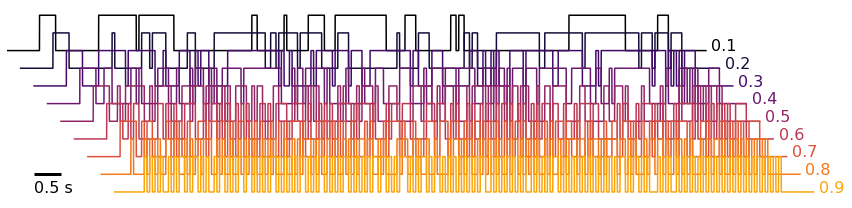

In [3]:
fig,ax = plt.subplots(1,1,figsize=(12,3))
for n, i in enumerate(np.arange(0.1,1,0.1)):
    PNLN,LNPN,setpn,t,ts = get_connectivity_timeseries(2,59428,1,switch_prob=i)
    plt.plot(0.25*n+t/1000,-0.5*n+ts,'k',linewidth=1.5,color=plt.cm.inferno(n/10.))
    plt.text(13.1+0.25*n,-0.5*n,f"{i:0.1f}",fontdict={"fontsize":16},color=plt.cm.inferno(n/10.))
plt.hlines(-3.5,0.5,1.0,color='k',linewidth=3)
plt.text(0.5,-4,"0.5 s",fontdict={"fontsize":16})
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(0,15.6)
plt.box(False)
plt.tight_layout()
plt.savefig(f"Figures/IntemittentTimeseries.svg")
# v_traces = get_traces(2,59428,1)
# LN_correlations,mat,module,order = get_LN_data(2,59428,1)

In [4]:
def unzip(switch_probx10=3):
    with zipfile.ZipFile(f'zip_0_{switch_probx10}.zip', 'r') as zip_ref:
        for member in tqdm(zip_ref.infolist(), desc='Extracting '):
            try:
                zip_ref.extract(member, "")
            except zipfile.error as e:
                pass
def clean_data():
    for i in os.listdir('Data/'):
        os.remove("Data/"+i)

In [5]:
clean_data()

In [6]:
for switch_prob in np.arange(0.1,1,0.1):
    unzip(int(switch_prob*10))
    results = []
    for i in tqdm(range(1,11)):
        for j in [13674, 59428, 72957, 84932, 85036]:
            LN_correlations,mat,module,order = get_LN_data(i,j)
            for k in range(10):
                correlation = np.corrcoef(np.nan_to_num(LN_correlations[k]).flatten(),1-mat.flatten())[0,1]
                random_shuffles = [np.random.choice(np.arange(30),size=30,replace=False) for x in range(1000)]
                shuffled = np.mean([np.corrcoef(np.nan_to_num(LN_correlations[k]).flatten(),1-mat[:,order][order,:].flatten())[0,1] for order in random_shuffles])
                results.append((correlation,shuffled))
    results=np.array(results)
    results = pd.DataFrame(results,columns=["Original","Shuffled"])
    results.to_csv(f"AnalysedData/LNCorrelationAnalysis_0_{int(switch_prob*10)}.csv")

    results = []
    for i in tqdm(range(1,11)):
        for j in [13674, 59428, 72957, 84932, 85036]:
            LN_correlations,mat,module,order = get_LN_data(i,j)
            for k in range(10):
                cluster_model = KMeans(n_clusters=int(np.max(module)))
                cluster_model.fit((1-LN_correlations[k])/2)
                f_correctpairs = rand_score(cluster_model.labels_,np.int32(module-1))
                random_clustering = [np.random.choice(np.arange(4),size=30) for x in range(1000)]
                shuffled = np.mean([rand_score(cluster_model.labels_,cluster) for cluster in random_clustering])
                results.append((f_correctpairs,shuffled))
    results = np.array(results)
    results = pd.DataFrame(results,columns=["Newman","Random"])
    results.to_csv(f"AnalysedData/LNReconstructionAnalysis_0_{int(switch_prob*10)}.csv")

    results = []
    for i in tqdm(range(1,11)):
        for j in [13674, 59428, 72957, 84932, 85036]:
            spike_dist,module_dist = get_PN_data(i,j)
            for k in range(10):
                correlation = np.corrcoef(np.nan_to_num(spike_dist[k]).flatten(),module_dist.flatten())[0,1]
                random_shuffles = [np.random.choice(np.arange(9),size=9,replace=False) for x in range(1000)]
                shuffled = np.mean([np.corrcoef(np.nan_to_num(spike_dist[k]).flatten(),module_dist[:,order][order,:].flatten())[0,1] for order in random_shuffles])
                results.append((correlation,shuffled))
    results=np.array(results)
    results = pd.DataFrame(results,columns=["Original","Shuffled"])
    results.to_csv(f"AnalysedData/PNCorrelationAnalysis_0_{int(switch_prob*10)}.csv")

    results= [[],[]]
    for i in tqdm(range(1,11)):
        summary_matrix,within,across = odor_analysis(i)
        for j in within:
            results[0].append(j)
        for j in across:
            results[1].append(j)
    N = max(len(results[0]),len(results[1]))
    temp = np.nan*np.ones((N,2))
    temp[:len(results[0]),0] = results[0]
    temp[:len(results[1]),1] = results[1]
    results=temp
    results = pd.DataFrame(results,columns=["Within","Across"])
    results.to_csv(f"AnalysedData/OdorComparision_0_{int(switch_prob*10)}.csv")

    results= []
    for time in tqdm(np.arange(0.5,13.5,0.5)):
        for i in range(1,11):
            summary_matrix,within,across = odor_analysis(i,time=time)
            for j in within:
                if not np.isnan(j):
                    results.append((time,"Within Odors",j))
            for j in across:
                if not np.isnan(j):
                    results.append((time,"Across Odors",j))
    results=np.array(results)
    results = pd.DataFrame(results,columns=["Time","LN Dynamics Correlation","Correlation"])
    results['Time'] = np.float32(results['Time'])
    results['Correlation'] = np.float32(results['Correlation'])
    results.to_csv(f"AnalysedData/OdorComparisionTimeseries_0_{int(switch_prob*10)}.csv")

    clean_data()

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:534: UserWarning: Detected empty spike trains (rows) in the binned_spiketrain.
  warnings.warn(
D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:542: RuntimeWarning: invalid value encountered in true_divide
  res /= (stdx.T * stdx)
  0%|                                                                                           | 0/10 [00:00<?, ?it/s]D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:534: 

D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:534: UserWarning: Detected empty spike trains (rows) in the binned_spiketrain.
  warnings.warn(
D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:542: RuntimeWarning: invalid value encountered in true_divide
  res /= (stdx.T * stdx)
D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:534: UserWarning: Detected empty spike trains (rows) in the binned_spiketrain.
  warnings.warn(
D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:542: RuntimeWarning: invalid value encountered in true_divide
 

D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:534: UserWarning: Detected empty spike trains (rows) in the binned_spiketrain.
  warnings.warn(
D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:542: RuntimeWarning: invalid value encountered in true_divide
  res /= (stdx.T * stdx)
D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 70%|

 10%|████████▎                                                                          | 1/10 [00:29<04:25, 29.53s/it]D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 30%|████████████████████████▉                                                          | 3/10 [01:28<03:26, 29.47s/it]D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 40%|█████████████████████████████████▏                                                 | 4/10 [01:57<02:55, 29.30s/it

  0%|                                                                                           | 0/26 [00:00<?, ?it/s]D:\Anaconda3\envs\odor-states\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
  0%|                                                                                           | 0/26 [00:00<?, ?it/s]D:\Anaconda3\envs\odor-states\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
  0%|                                                                                           | 0/26 [00:00<?, ?it/s]D:\Anaconda3\envs\odor-states\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(Pea

In [ ]:
switch_prob

In [35]:
np.mean(np.random.choice(8,size=10000)-np.random.choice(6,size=10000)),np.quantile(np.random.choice(8,size=10000)-np.random.choice(6,size=10000),0.05),np.quantile(np.random.choice(8,size=10000)-np.random.choice(6,size=10000),0.95)

(0.9976, -4.0, 6.0)

In [84]:
results =[]
for mat_no in tqdm(range(1,11)):
    random_shuffles = [np.random.choice(np.arange(5),size=5,replace=False) for x in range(1000)]
    LN_inputs = []
    for odor in [13674, 59428, 72957, 84932, 85036]:
        PNLN,LNPN,setpn,_,_ = get_connectivity_timeseries(mat_no,odor,1)
        LN_inputs.append(PNLN@setpn)
    LN_odor_matrix = distance_matrix(LN_inputs,LN_inputs)
    PN_inputs = []
    for odor in [13674, 59428, 72957, 84932, 85036]:
        PNLN,LNPN,setpn,_,_ = get_connectivity_timeseries(mat_no,odor,1)
        PN_inputs.append(setpn)
    PN_odor_matrix = distance_matrix(PN_inputs,PN_inputs)
    summary_matrix,_,_ = odor_analysis(mat_no)
    corr_LN = np.corrcoef(summary_matrix[np.tril_indices(5,-1)],LN_odor_matrix[np.tril_indices(5,-1)])[0,1]
    corr_LN_shuffled = np.mean([np.corrcoef(summary_matrix[np.tril_indices(5,-1)],
                                            LN_odor_matrix[:,rs][rs,:][np.tril_indices(5,-1)])[0,1] 
                                for rs in random_shuffles])
    corr_PN = np.corrcoef(summary_matrix[np.tril_indices(5,-1)],PN_odor_matrix[np.tril_indices(5,-1)])[0,1]
    corr_PN_shuffled = np.mean([np.corrcoef(summary_matrix[np.tril_indices(5,-1)],
                                            PN_odor_matrix[:,rs][rs,:][np.tril_indices(5,-1)])[0,1] 
                                for rs in random_shuffles])
    results.append((corr_LN_shuffled,corr_LN,corr_PN,corr_PN_shuffled))
results=np.abs(np.array(results))
results = pd.DataFrame(results,columns=["LN Input\n(Shuffled)","LN Input","PN Input","PN Input\n(Shuffled)"])
results.to_csv("Data/OdorStructureComparison.csv")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.49s/it]
